### Purpose of the Notebook

The goal of this notebook is to visually demonstrate the _modeled_ effect of recrystallization on the tungsten alloy properties.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import warnings
from typing import List, Tuple
import sys
sys.path.append('../')
from common_util import NogamiUTSData,ProjectPaths,setup_plotting_format,setup_axis_default
import pickle
from pathlib import Path
from matplotlib.ticker import AutoMinorLocator
IMAGE_PATH = Path(
    'C:\\Users\\mlanahan3\\OneDrive - Georgia Institute of Technology\\gt_research_files\\fusion\\Thesis\\dissertation\\presentation\\images'
)

from matplotlib import rc
import pickle
rc('font',**{'family':'serif','serif':['Calibri'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
def setup_axis_presentation(ax: plt.Axes,labelsize = 16):
    
    """
    convinience function to set up the axis
    """
    ax.tick_params('both',labelsize = labelsize,which = 'both',direction = 'in')
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    return ax
#ignore warnings and set preference for matplotlib styles
warnings.filterwarnings("ignore")
#setup_plotting_format()
paths = ProjectPaths()

dbbt = {'W Plate (H)': 500.0,
        'K-W Plate (H)': 350.0,
        'K-W3%Re Plate (H)': 300.0,
        'K-W3%Re Plate (L)': 300.0}

RT = {'W Plate (H)': 1300.0,
        'K-W Plate (H)': 1300.0,
        'K-W3%Re Plate (H)': 1300.0,
        'K-W3%Re Plate (L)': 1300.0}

delta_Su = {'W Plate (H)': 271.761,
            'K-W Plate (H)': 251.897,
            'K-W3%Re Plate (H)': 293.489,
            'K-W3%Re Plate (L)': 212.309}

delta_tr = {'W Plate (H)': -36.5166,
            'K-W Plate (H)': -38.3921,
            'K-W3%Re Plate (H)': -30.2196,
            'K-W3%Re Plate (L)': -30.2196}

### Single Alloy

Plotting the modeled effect of recrystallization for a _single_ alloy. The below demonstrates the _constant_ offset for $\Delta_{rx} S_u(T)$ and the offset 

$$
\Delta_{rx} \varepsilon_{u}(T) = \frac{\varepsilon_{u,0}(T)}{\varepsilon_{tr,0}(T)} \Delta_{rx} \varepsilon_{tr}(T)
$$

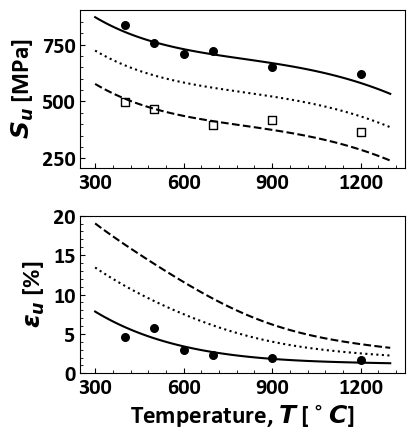

In [4]:
fig,axes = plt.subplots(ncols = 1,nrows = 2,figsize=(4.25,4.5))

material = 'K-W3%Re Plate (H)'
data = NogamiUTSData()

#UTS
labels = [r'As Recieved',r'Recrystallized']
for mat,symbol,fc,label in zip(['',' Rx'],['o','s'],['k','w'],labels):
    df = data.get_df(material + mat)
    df = df[df.index < RT[material]]
    df = df[df.index > dbbt[material]]
    axes[0].scatter(df.index,df.to_numpy(),s = 30,marker = symbol,edgecolor = 'k',
                  facecolor = fc,label = label)

with open(paths.MODEL.joinpath(material + '_uts.pkl'),'rb') as f:
    model = pickle.load(f)

x = np.linspace(dbbt[material],RT[material],100)
y = model.predict(x.reshape(-1,1))
axes[0].plot(x,y,'k-')
axes[0].plot(x,y- 0.5*delta_Su[material],'k:')
axes[0].plot(x,y- delta_Su[material],'k--')


#uniform elongation
ue = data.get_df('UE [%] ' + material)
with open(paths.MODEL.joinpath(material + '_ue.pkl'),'rb') as f:
    ue_model = pickle.load(f)

with open(paths.MODEL.joinpath(material + '_te.pkl'),'rb') as f:
    te_model = pickle.load(f)

ue_rx = ue_model.predict(x.reshape(-1,1)) - ue_model.predict(x.reshape(-1,1))/te_model.predict(x.reshape(-1,1))*delta_tr[material]
ue_half = ue_model.predict(x.reshape(-1,1)) - 0.5*ue_model.predict(x.reshape(-1,1))/te_model.predict(x.reshape(-1,1))*delta_tr[material]
ue = ue[ue.index < RT[material]]
ue = ue[ue.index > dbbt[material]]
axes[1].scatter(ue.index,ue.to_numpy(),s = 30,marker = 'o',edgecolor = 'k',
                facecolor = 'k')

axes[1].plot(x,ue_model.predict(x.reshape(-1,1)),'k-')
axes[1].plot(x,ue_half,'k:')
axes[1].plot(x,ue_rx,'k--')


for ax in axes:
    setup_axis_presentation(ax,labelsize = 16)
    ax.set_xticks(np.arange(300,1300,300))

axes[0].set_xlabel('')
axes[1].set_xlabel(r'Temperature, $T$ [$^\circ C$]',fontsize = 18)
axes[0].set_ylabel(r'$S_u$ [MPa]',fontsize = 18)
axes[1].set_ylabel(r'$\varepsilon_{u}$ [%]',fontsize = 18)
axes[1].set_yticks(np.arange(0,21,5))

fig.tight_layout()

fig.savefig( IMAGE_PATH / 'K-W3pRe_Plate_(H)_UTS_and_UE.svg')
